# Data First Look and Exploratory Analysis
### This notebook is the first process in our project. We load and clean the data we scraped and take a look to see what we can learn from it. 

The functions to load and clean the data are written and documented in src/preprocess.py

The function to plot are written and documented in src/plotting.py

The functions for the statitiscal tests are  written and documented in src/stat_tests.py


In [9]:
from src.preprocess import clean_data, merge_data_folder, cut_into_bins
from src.plotting import plot_correlation_heatmap, barplot_multiple_dataframes, bar_plot_many_datapoints
from src.stat_tests import one_way_anova, pairwise_t_tests
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '{:.6f}'.format(x) if pd.api.types.is_float_dtype(x) else x)


In [10]:
df = merge_data_folder("data").drop(['Unnamed: 0'],axis=1)
df = clean_data(df)

In [11]:
# let's save that clean data dataframe for later use
df.to_csv("./preprocessed_data/clean_data.csv", sep="|",)

In [12]:
print("We collected {} unique English tweets".format(len(df)))
print("The columns we collected for each are: ", df.columns.values)

We collected 53559 unique English tweets
The columns we collected for each are:  ['tweet_id' 'tweets' 'dates' 'username' 'url' 'replies' 'retweets'
 'quote_retweets' 'likes' 'leaning' 'n_tokens']


All columns are self-explanatory but leaning which denotes where the authors of each tweet stand according to themselves. The values are either Palestine, Israel, or center (for those who present themselves as non-biased). n_tokens is a column we added in the last step which simply the number of tokens in each tweet.

Between Israel and Palestine, we collected a roughly equal number of tweets. 

In [13]:
df.leaning.value_counts()

leaning
israel       26261
palestine    25800
center        1498
Name: count, dtype: int64

In [14]:
# Let's select the numerical columns so that we can do some numerical analysis on them
numerical_cols=df.select_dtypes(include='number').columns.tolist()
numerical_cols.remove("tweet_id")
# Let's also split the dataframe into the 3 different camps
df_p = df[df["leaning"]=="palestine"]
df_i = df[df["leaning"]=="israel"]
df_c = df[df["leaning"]=="center"]

Now let's look at the mean values of replies, retweets, quote retweets, and likes for the dataframe containing all the tweets
and the dataframes containing only tweets of the three camps

In [15]:
df[numerical_cols].mean()

replies           324.126554
retweets         1604.106294
quote_retweets     96.759740
likes            4568.232916
n_tokens           37.439422
dtype: float64

In [16]:
means_i = df_i[numerical_cols].mean()
means_p = df_p[numerical_cols].mean()
means_c = df_c[numerical_cols].mean()

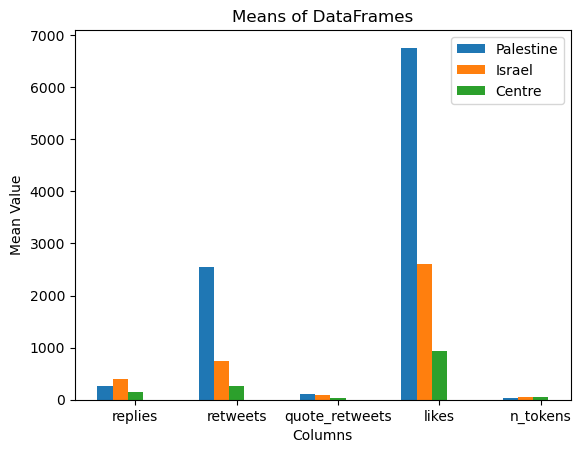

In [17]:

barplot_multiple_dataframes(dataframes = [means_p, means_i, means_c], 
                            labels = ["Palestine", "Israel", "Centre"],
                            title = "Means of DataFrames", 
                            xlabel = "Columns",
                            ylabel = "Mean Value")


As seen above:

Tweets from authors leaning towards the Palestinian bloc have predominantly higher numbers of likes and retweets while the Israeli bloc has higher number of replies. The centre block has the lowest mean in all. 


Let's do the same thing but for medians in order to account for outliers.


In [18]:

median_i = df_i[numerical_cols].median()
median_p = df_p[numerical_cols].median()
median_c = df_c[numerical_cols].median()
df[numerical_cols].median()

replies           48.000000
retweets         158.000000
quote_retweets    13.000000
likes            573.000000
n_tokens          26.000000
dtype: float64

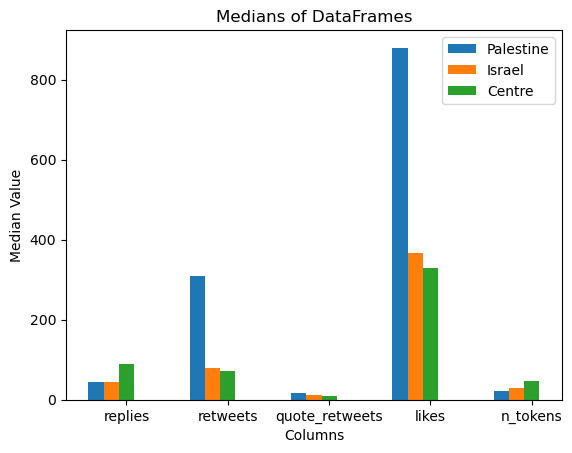

In [19]:

barplot_multiple_dataframes(dataframes = [median_p, median_i, median_c], 
                            labels = ["Palestine", "Israel", "Centre"],
                            title = "Medians of DataFrames", 
                            xlabel = "Columns",
                            ylabel = "Median Value")


We get the exact same trend in all cases except in replies where we see the centre bloc take the top instead.

Let's look at correlations between our variables.

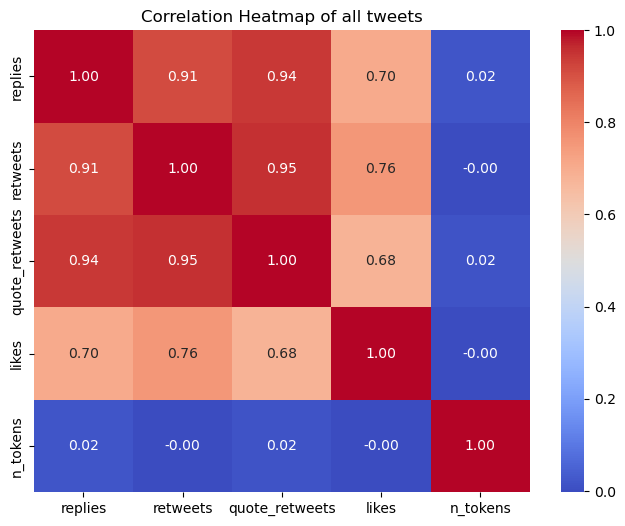

In [20]:

plot_correlation_heatmap(df[numerical_cols],'Correlation Heatmap of all tweets')


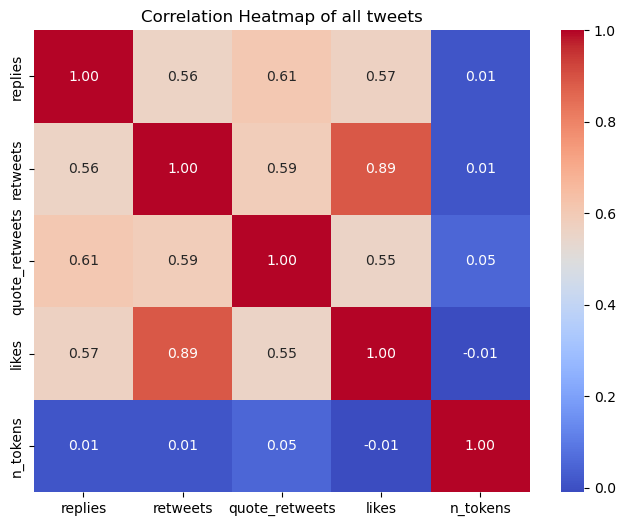

In [21]:
plot_correlation_heatmap(df_p[numerical_cols],'Correlation Heatmap for only Palestine-leaning authors')


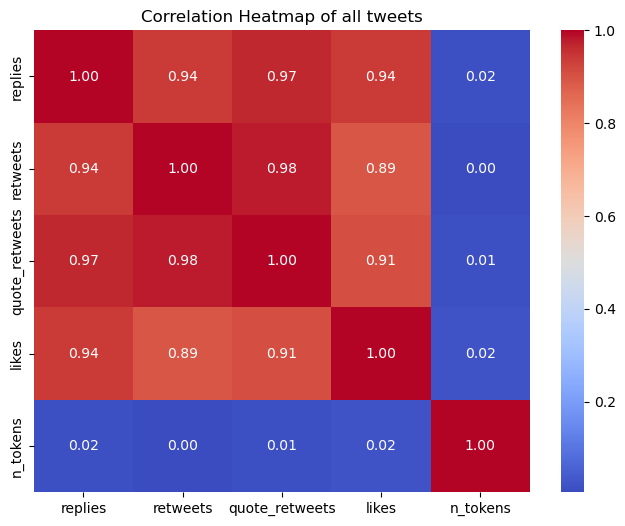

In [22]:
plot_correlation_heatmap(df_i[numerical_cols],'Correlation Heatmap for only Israel-leaning authors')


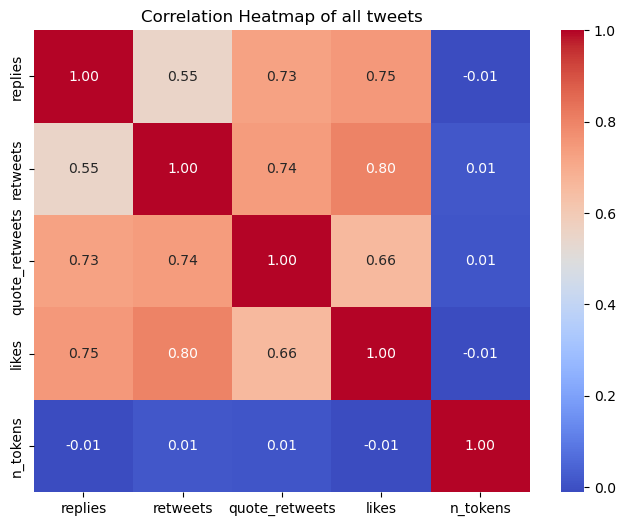

In [23]:
plot_correlation_heatmap(df_c[numerical_cols],'Correlation Heatmap for only Centre-leaning authors')


We see that for Israel-leaning tweets, there's a high correlation between replies, retweets, quote retweets, and likes. meaning that tweets that get high traction usually get all kinds of traction (not necessarily from the same users). 

This correlation isn't as strong for the Palestinian-leaning tweets except for the relationship between retweets and likes which is high.

One interesting point to take into consideration is that likes and retweets show definite agreement with the contents of a tweet while quote retweets and replies can be used to criticise a tweet. 

Another interesting point is that there's 0 correlation betweet the length of a tweet and the interaction it gets. People apparently react similary to all lengths of tweets. But we can't know for sure yet. Let's do some more tests.

let's define a function that tests a certain columns of buckets of data that fall witihin certain intervals of another column

In [24]:
def pairwise_test_column_based_on_group(df, 
                                        alpha,
                                        column_to_test,
                                        column_to_group_by,
                                        bins,
                                        group_labels,
                                        tweets_title = "",
                                    ):
    df_temp = df.copy()
    df_temp = cut_into_bins(df=df_temp,
                    column=column_to_group_by,
                    bins=bins, 
                    labels= group_labels, 
                    new_col_name= "bins")
    data = dict(df_temp.dropna(subset=[column_to_test]).groupby("bins")[column_to_test].apply(list))
    results = pairwise_t_tests(data, alpha=alpha)
    group_means = df_temp.groupby("bins")[column_to_test].mean()
    barplot_multiple_dataframes(dataframes = [group_means],
                                 labels = group_means.index.to_list(),
                                 title= "mean of {} for {}".format(column_to_test, tweets_title), 
                                 xlabel= "bins",
                                 ylabel= "mean of group",
                                 legend=False
    )
 



groups with significant differences:  ['0-5 and 30-50', '0-5 and 50-100', '5-10 and 15-30', '5-10 and 30-50', '5-10 and 50-100', '5-10 and 100-500', '5-10 and 500-5000', '10-15 and 15-30', '10-15 and 30-50', '10-15 and 50-100', '15-30 and 30-50', '15-30 and 50-100', '30-50 and 100-500', '50-100 and 100-500']
group wihout signifcant difference:  ['0-5 and 5-10', '0-5 and 10-15', '0-5 and 15-30', '0-5 and 100-500', '0-5 and 500-5000', '5-10 and 10-15', '10-15 and 100-500', '10-15 and 500-5000', '15-30 and 100-500', '15-30 and 500-5000', '30-50 and 50-100', '30-50 and 500-5000', '50-100 and 500-5000', '100-500 and 500-5000']


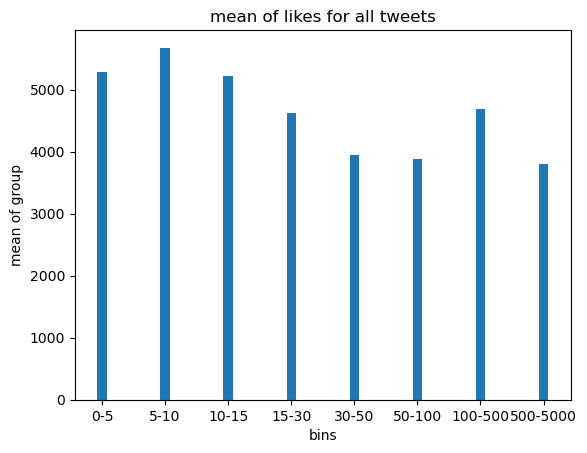

In [25]:
# in this next example we'll group the data based on number of tokens and test how similar they are when it comes to number of likes


results = pairwise_test_column_based_on_group(df, 
                                              alpha = 0.05,
                                              column_to_test="likes", 
                                              column_to_group_by="n_tokens", 
                                              bins = [0, 5, 10, 15, 30, 50, 100, 500, 5000],
                                              group_labels = ["0-5","5-10", "10-15", "15-30", "30-50","50-100", "100-500", "500-5000"],
                                              tweets_title = "all tweets",
                                              )    

groups with significant differences:  ['0-5 and 30-50', '0-5 and 50-100', '0-5 and 100-500', '5-10 and 50-100', '5-10 and 100-500', '10-15 and 15-30', '10-15 and 30-50', '10-15 and 50-100', '10-15 and 100-500', '15-30 and 100-500', '30-50 and 100-500', '50-100 and 100-500']
group wihout signifcant difference:  ['0-5 and 5-10', '0-5 and 10-15', '0-5 and 15-30', '0-5 and 500-5000', '5-10 and 10-15', '5-10 and 15-30', '5-10 and 30-50', '5-10 and 500-5000', '10-15 and 500-5000', '15-30 and 30-50', '15-30 and 50-100', '15-30 and 500-5000', '30-50 and 50-100', '30-50 and 500-5000', '50-100 and 500-5000', '100-500 and 500-5000']


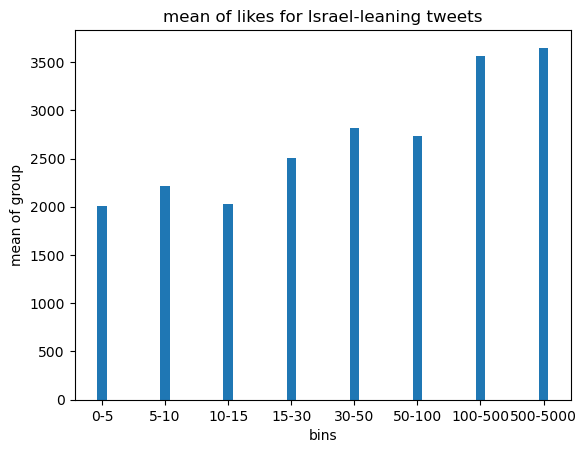

In [26]:

results = pairwise_test_column_based_on_group(df_i, 
                                              alpha = 0.05,
                                              column_to_test="likes", 
                                              column_to_group_by="n_tokens", 
                                              bins = [0, 5, 10, 15, 30, 50, 100, 500, 5000],
                                              group_labels = ["0-5","5-10", "10-15", "15-30", "30-50","50-100", "100-500", "500-5000"],
                                              tweets_title = "Israel-leaning tweets",
                                              
                                              )  

groups with significant differences:  ['0-5 and 5-10', '0-5 and 10-15', '0-5 and 30-50', '0-5 and 100-500', '5-10 and 15-30', '5-10 and 30-50', '5-10 and 100-500', '10-15 and 15-30', '10-15 and 30-50', '10-15 and 100-500', '15-30 and 30-50', '15-30 and 100-500', '30-50 and 50-100', '30-50 and 100-500', '50-100 and 100-500', '100-500 and 500-5000']
group wihout signifcant difference:  ['0-5 and 15-30', '0-5 and 50-100', '0-5 and 500-5000', '5-10 and 10-15', '5-10 and 50-100', '5-10 and 500-5000', '10-15 and 50-100', '10-15 and 500-5000', '15-30 and 50-100', '15-30 and 500-5000', '30-50 and 500-5000', '50-100 and 500-5000']


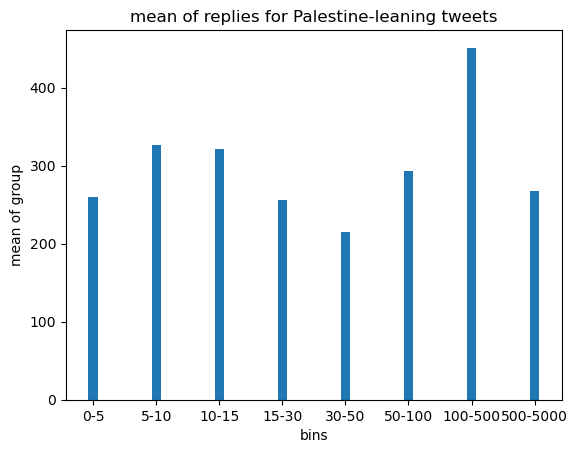

In [27]:

results = pairwise_test_column_based_on_group(df_p, 
                                              alpha = 0.05,
                                              column_to_test="replies", 
                                              column_to_group_by="n_tokens", 
                                              bins = [0, 5, 10, 15, 30, 50, 100, 500, 5000],
                                              group_labels = ["0-5","5-10", "10-15", "15-30", "30-50","50-100", "100-500", "500-5000"],
                                              tweets_title = "Palestine-leaning tweets",
                                              
                                              )  

groups with significant differences:  ['0-5 and 10-15', '0-5 and 15-30', '0-5 and 30-50', '0-5 and 50-100', '0-5 and 100-500', '30-50 and 50-100']
group wihout signifcant difference:  ['0-5 and 5-10', '0-5 and 500-5000', '5-10 and 10-15', '5-10 and 15-30', '5-10 and 30-50', '5-10 and 50-100', '5-10 and 100-500', '5-10 and 500-5000', '10-15 and 15-30', '10-15 and 30-50', '10-15 and 50-100', '10-15 and 100-500', '10-15 and 500-5000', '15-30 and 30-50', '15-30 and 50-100', '15-30 and 100-500', '15-30 and 500-5000', '30-50 and 100-500', '30-50 and 500-5000', '50-100 and 100-500', '50-100 and 500-5000', '100-500 and 500-5000']


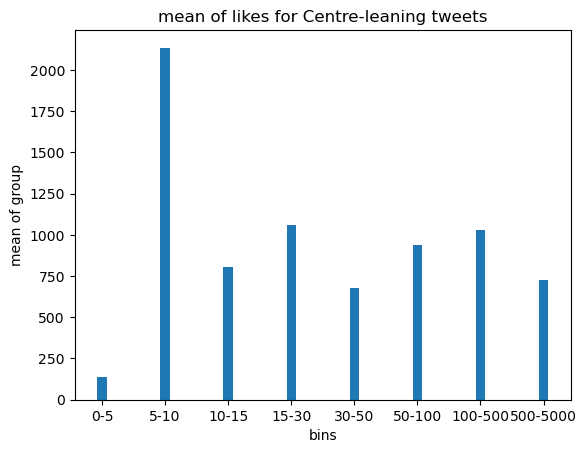

In [28]:

results = pairwise_test_column_based_on_group(df_c, 
                                              alpha = 0.05,
                                              column_to_test="likes", 
                                              column_to_group_by="n_tokens", 
                                              bins = [0, 5, 10, 15, 30, 50, 100, 500, 5000],
                                              group_labels = ["0-5","5-10", "10-15", "15-30", "30-50","50-100", "100-500", "500-5000"],
                                              tweets_title = "Centre-leaning tweets",
                                              
                                              )  

From the results above we can see that the length of tweets can actually make a significant difference (at the 0.05 level) in number of likes but a linear consistent trend between number of likes and the length of the tweets was not found.

One interesting thing to note is that the means on a plot can be misleading.
For example, while the graph shows that 500-5000 number of tokens in the Israel-leaning tweets looks high on a plot, the difference between that bucket and the 50-100 bucket for example isn't actually statistically significant and that's because the number of tweets in that bucket wasn't big enough to make a difference that's statistically significant. we see in the next cell that this number is only 145 tweets.

A better to show this data would be a boxplot which we've implemented but since we have a huge range of likes, it doesn't look readable. In any case, since we already conducted the statistical analysis tests, there's no need to.

Other tests for the number of replies, retweets, quote retweets show the same results in relation to tweet length.

In [29]:
# this shows how many tweets are longer than 500 tokens
df_i[df_i["n_tokens"]>500].shape[0]

145

One more thing to do is to test if there's a significant difference between number of likes, replied, retweets, and quote retweets between those Isreal-leaning tweets and Palestine-leaning tweets. That difference in mean and median was seen in the first couple plots but it would be important to show its significance statistically

In [30]:
group = [df_i.dropna(subset=["likes"]).likes, df_p.dropna(subset=["likes"]).likes]
one_way_anova(*group, alpha = 0.05)

F-statistic: 753.5274075026518
P-value: 1.0439748552143812e-164
Reject the null hypothesis. There is a significant difference between at least two groups.


In [31]:
group = [df_i.dropna(subset=["replies"]).replies, df_p.dropna(subset=["replies"]).replies]
one_way_anova(*group, alpha = 0.05)

F-statistic: 39.20137106051621
P-value: 3.854001471484562e-10
Reject the null hypothesis. There is a significant difference between at least two groups.


In [32]:
group = [df_i.dropna(subset=["quote_retweets"]).quote_retweets, df_p.dropna(subset=["quote_retweets"]).quote_retweets]
one_way_anova(*group, alpha = 0.05)

F-statistic: 1.6003507095839737
P-value: 0.20586055762843453
Fail to reject the null hypothesis. There is no significant difference between the groups.


In [33]:
group = [df_i.dropna(subset=["retweets"]).retweets, df_p.dropna(subset=["retweets"]).retweets]
one_way_anova(*group, alpha = 0.05)

F-statistic: 144.2623192876099
P-value: 3.455090973277296e-33
Reject the null hypothesis. There is a significant difference between at least two groups.


In [34]:
group = [df_i.dropna(subset=["n_tokens"]).n_tokens, df_p.dropna(subset=["n_tokens"]).n_tokens]
one_way_anova(*group, alpha = 0.05)

F-statistic: 512.7878825761077
P-value: 5.528588674716035e-113
Reject the null hypothesis. There is a significant difference between at least two groups.


We can conclude that:

- Palestinian-leaning tweets get more likes and retweets on average than those of Israeli-leaning authors

- Israeli-leaning tweets get more replies and are longer in length on average than those of Palestenian-leaning authors

- No difference at the 0.05 significance level in the number of quote retweets


# for one last step, let's see how the user are divided among different camps


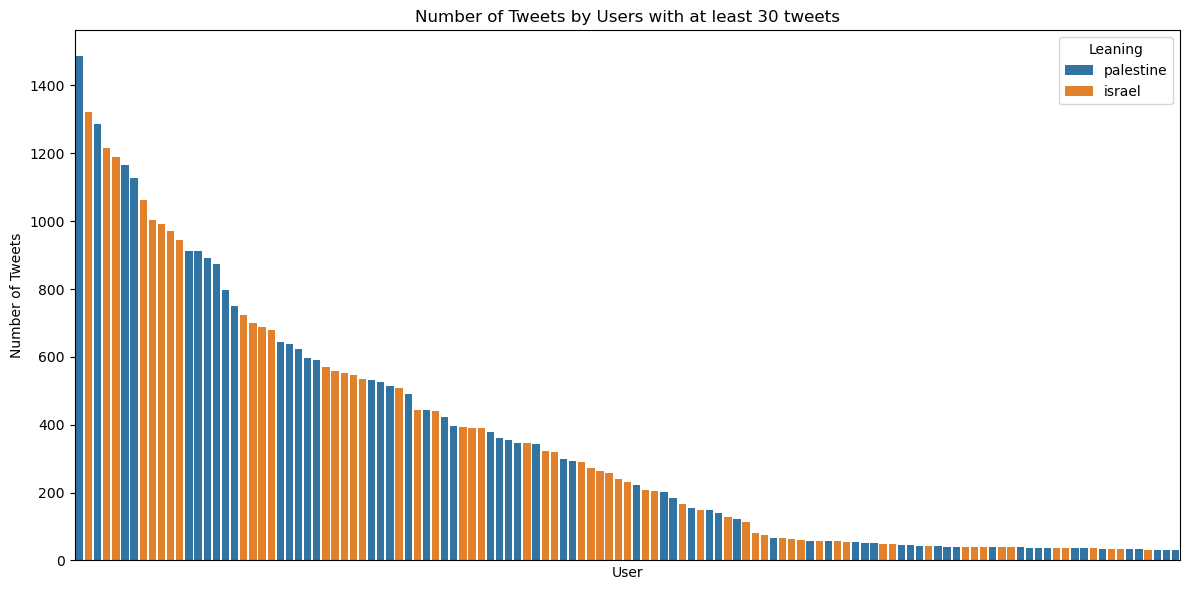

In [35]:
df_users=df.groupby("username").count()
df_users["leaning"]=df.groupby("username")["leaning"].unique().apply(lambda x: x[0])
bar_plot_many_datapoints(
    df = df_users[df_users["tweets"]>30].sort_values(by="tweets", ascending = False),
    x_column="username",
    y_column = "tweets",
    hue= "leaning",
    x_label="User",
    y_label="Number of Tweets",
    title="Number of Tweets by Users with at least 30 tweets",
    legend_title="Leaning"
)
   